## 第一部分

### 简答题

1. 为什么激活函数是训练一个多层感知机（MLP）的关键要素

**答：因为没有激活函数/线性激活函数的话，MLP组合再多层还是线性的。 TODO： 展示RELU组合可以拟合任意的函数；而且激活函数决定了导数（梯度），如果激活函数是阶跃函数，它导数一直是0，梯度下降无法更新它**

2. 列举三种常用的激活函数，说明一下它们的大概形状

**答：sigmoid，tanh，ReLU及其变体**

3. 反向传播的算法解决什么问题，如何工作的

**答：反向传播是一种用于训练人工神经网络的技术。它首先计算成本函数关于每个模型参数（所有权重和偏差）的梯度，然后使用这些梯度执行梯度下降步骤。这个反向传播步骤通常执行数千次或数百万次，使用许多训练批次，直到模型参数收敛到（希望）最小化成本函数的值。为了计算梯度，反向传播使用链式法则+缓存中间结果计算梯度，它先进行正向传播，计算当前训练批次的每个节点的值，然后执行反向传递，一次性计算所有梯度。**

4. 列出可以在基本MLP（不考虑其他神经网络架构）中进行调整的所有超参数？如果MLP过拟合训练数据，如何调整这些超参数来解决该问题？

**答：隐藏层的数量、每个隐藏层的神经元数量以及每个隐藏层和输出层使用的激活函数。通常，ReLU 激活函数（或其变体）是隐藏层的良好默认激活函数。对于输出层，通常需要使用 S 型激活函数进行二分类，使用 Softmax 激活函数进行多分类，或者不使用激活函数进行回归。如果 MLP 对训练数据过拟合，可以尝试减少隐藏层的数量并减少每个隐藏层的神经元数量。**

5. 假设有一个MLP，该MLP由一个输入层，10个特征，随后是一个包含50个神经元的隐藏层，最后是3个神经元组成的输出层。所有人工神经元都使用ReLU激活函数。

   a. 输入矩阵X的形状是什么

   b. 隐藏层的权重W_hidden及其偏置b_hidden的形状分别是什么

   c. 输出层的权重W_output及其偏置b_output的形状是什么

   d. 网络输出矩阵Y的形状是什么

   e. 写出输出矩阵Y的计算公式，满足Y是W_hidden, b_hidden, W_output, b_output的函数

**答：输入矩阵 X 的形状为 m × 10，其中 m 表示训练批次大小。
隐藏层权重矩阵 Wh 的形状为 10 × 50，其偏置向量 bh 的长度为 50。
输出层权重矩阵 Wo 的形状为 50 × 3，其偏置向量 bo 的长度为 3。
网络输出矩阵 Y 的形状为 m × 3。
Y = ReLU(ReLU(X Wh + bh) Wo + bo)。回想一下，ReLU 函数只是将矩阵中的每个负数设置为零。另请注意，当向矩阵添加偏置向量时，它会被添加到矩阵的每一行，公式里也有广播。**

6. 如果要将电子邮件分类为垃圾邮件或正常邮件，需要在输出层中有多少个神经元？应该在输出层中使用什么激活函数？相反，如果想解决MNIST图片分类问题，则在输出层中需要有多少个神经元，应该使用哪种激活函数？如何使神经网络预测 回归话题里提到的房价？

**答：要将电子邮件分类为垃圾邮件或正常邮件，只需在神经网络的输出层中放置一个神经元即可——例如，指示该电子邮件为垃圾邮件的概率。估算概率时，通常会在输出层使用 S 型激活函数。但如果要处理 MNIST，则需要在输出层放置 10 个神经元，并且必须将 S 型函数替换为 Softmax 激活函数，后者可以处理多个类别，每个类别输出一个概率。如果希望神经网络预测房价，则只需要一个输出神经元，并且在输出层中完全不使用任何激活函数。注意：当待预测值可能相差多个数量级时，您可能需要预测目标值的对数，而不是直接预测目标值。只需计算神经网络输出的指数即可得到估计值（因为 exp(log v) = v）。**

### 编程题

在MNIST数据集上训练深度MLP（可以使用tf.keras.datasets.mnist.load_data()加载它）。看看是否可以通过手动调整超参数获得98%以上的精度。

首先尝试使用课堂上介绍的方法搜索最佳学习率（即通过以指数方式增加学习率，根据学习率变化绘制训练损失，并找到损失激增的点）。

接下来，尝试使用Keras Tuner调整超参数——保存检查点，使用早停，并使用TensorBoard绘制学习曲线。

In [17]:
import tensorflow as tf
import numpy as np
from pathlib import Path

In [3]:
(X_train_full, y_train_full), (X_test_full, y_test_full) = tf.keras.datasets.mnist.load_data()

In [4]:
# 拆出验证集
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


In [5]:
# 像素压缩
X_train, X_valid, X_test_full = X_train / 255., X_valid / 255., X_test_full / 255.

In [6]:
np.ptp(X_train) # 检查是否超过1

1.0

In [6]:
# 搭建基础模型
def build_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    input_ = tf.keras.layers.Input(shape=(28,28))
    flat_in = tf.keras.layers.Flatten()(input_)

    norm_layer = tf.keras.layers.Normalization()
    norm_in = norm_layer(flat_in)
    hidden1 = tf.keras.layers.Dense(300, activation='relu')(norm_in)
    hidden2 = tf.keras.layers.Dense(100, activation='relu')(hidden1)
    output = tf.keras.layers.Dense(10, activation="softmax")(hidden2)

    model = tf.keras.Model(inputs=[input_], outputs=[output])
    return model

In [28]:
# 检查是否可以训练
model = build_model()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.get_layer("normalization").adapt(X_train.reshape(-1, 28*28))
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2303 - accuracy: 0.9352 - val_loss: 0.1253 - val_accuracy: 0.9658
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1021 - accuracy: 0.9703 - val_loss: 0.1167 - val_accuracy: 0.9670
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0755 - accuracy: 0.9770 - val_loss: 0.1046 - val_accuracy: 0.9756
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0540 - accuracy: 0.9831 - val_loss: 0.1174 - val_accuracy: 0.9718
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0520 - accuracy: 0.9852 - val_loss: 0.1153 - val_accuracy: 0.9736
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0438 - accuracy: 0.9875 - val_loss: 0.1364 - val_accuracy: 0.9762
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0334 - accuracy: 0.9898 - val_loss: 0.1496 - val_accuracy:

In [7]:
# 搜索最佳学习率：即通过以指数方式增加学习率，根据学习率变化绘制训练损失，并找到损失激增的点
import matplotlib.pyplot as plt

class LearningRateChange(tf.keras.callbacks.Callback):
    def __init__(self, min_learning_rate, max_learning_rate, batches_per_epoch):
        super().__init__()
        self.min_learning_rate = min_learning_rate
        self.learning_rate = self.min_learning_rate
        self.power = np.power(max_learning_rate / min_learning_rate, 1 / batches_per_epoch)
        self.losses = []
        self.learning_rates = []

    def on_batch_end(self, epoch, logs):
        self.learning_rates.append(self.learning_rate)
        self.losses.append(logs["loss"])

        self.learning_rate *= self.power
        self.model.optimizer.learning_rate = self.learning_rate

    def on_train_end(self, logs):
        plt.gca().set_xscale("log")
        plt.plot(self.learning_rates, self.losses)

        # 找到最小 loss 的位置
        min_idx = np.argmin(self.losses)
        best_lr = self.learning_rates[min_idx]
        best_loss = self.losses[min_idx]

        # 画竖线
        plt.vlines(x=best_lr, ymin=plt.ylim()[0], ymax=best_loss,
                   colors="red", linestyles="--", label=f"best lr = {best_lr:.2e}")

        # 标注文本
        plt.scatter([best_lr], [best_loss], color="red")
        plt.text(best_lr, best_loss, f"lr={best_lr:.2e}", color="red", ha="left", va="bottom")

        plt.xlabel("Learning rate")
        plt.ylabel("Loss")
        plt.title("Learning rate vs Loss")
        plt.legend()
        plt.show()
        plt.show()


1719/1719 [==============================] - 3s 2ms/step - loss: 1.3796 - accuracy: 0.5785 - val_loss: 2.3154 - val_accuracy: 0.1064


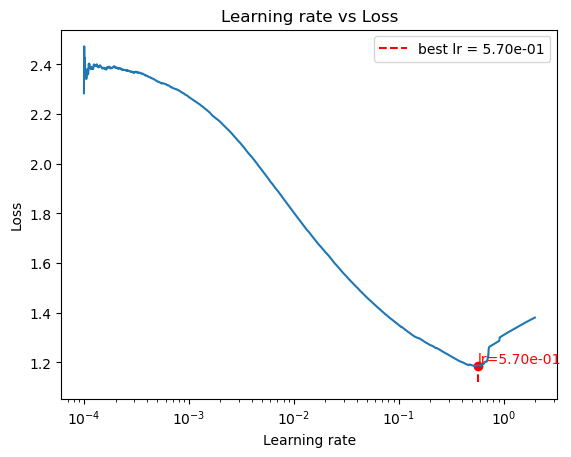

In [8]:
min_learning_rate = 1e-4
max_learning_rate = 2
batch_size = 32
batches_per_epoch = np.ceil(X_train.shape[0] / batch_size)

model = build_model()


model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.get_layer("normalization").adapt(X_train.reshape(-1, 28*28))
model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[LearningRateChange(min_learning_rate, max_learning_rate, batches_per_epoch)])

In [9]:
# 学习率过了0.566 ，也就是0.6左右，损失开始往上走，-> 学习率拐点的10分之一 选择0.06
optimizer = tf.keras.optimizers.SGD(learning_rate=0.06)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)
check_points_cb = tf.keras.callbacks.ModelCheckpoint("./models/mnist_best_weights.weights.h5", save_best_only=True, save_weights_only=True)

model = build_model()
model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.get_layer("normalization").adapt(X_train.reshape(-1, 28*28))
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[check_points_cb, early_stopping_cb])

Epoch 1/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2721 - accuracy: 0.9266 - val_loss: 0.1473 - val_accuracy: 0.9666
Epoch 2/100
1719/1719 [==============================] - 3s 1ms/step - loss: 0.1079 - accuracy: 0.9699 - val_loss: 0.1460 - val_accuracy: 0.9694
Epoch 3/100
1719/1719 [==============================] - 3s 1ms/step - loss: 0.0667 - accuracy: 0.9810 - val_loss: 0.0976 - val_accuracy: 0.9746
Epoch 4/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0435 - accuracy: 0.9887 - val_loss: 0.0982 - val_accuracy: 0.9762
Epoch 5/100
1719/1719 [==============================] - 3s 1ms/step - loss: 0.0277 - accuracy: 0.9932 - val_loss: 0.1159 - val_accuracy: 0.9738
Epoch 6/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0194 - accuracy: 0.9958 - val_loss: 0.1155 - val_accuracy: 0.9746
Epoch 7/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0115 - accuracy: 0.9979 - val_loss: 0.0948 - val_ac

In [10]:
# 恢复最佳模型
model.load_weights("./models/mnist_best_weights.weights.h5")

In [11]:
model.evaluate(X_test_full, y_test_full)

313/313 [==============================] - 0s 1ms/step - loss: 13.1124 - accuracy: 0.9766


[13.112380981445312, 0.9765999913215637]

In [8]:
#  keras Tuner探索 网络的层数 + 神经元数量，激活函数（relu, sigmoid, tanh),  优化器（sgd，adam）
import keras_tuner as kt

def build_model(hp, learning_rate):
    num_layers = hp.Int("num_layers", min_value=1, max_value=8)
    num_neurons = hp.Int("num_neurons", min_value=16, max_value=256)

    activation = hp.Choice("activation", ["relu", "tanh", "sigmoid"])
    optimizer = hp.Choice("optimizer", ["sgd", "adam"])

    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(num_layers):
        model.add(tf.keras.layers.Dense(num_neurons, activation=activation, kernel_initializer="he_normal" if activation == "relu" else "glorot_uniform"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [18]:
rnd_search_tuner = kt.RandomSearch(lambda hp: build_model(hp, 0.06), objective="val_accuracy", max_trials=20, overwrite=True, directory="./models/my_mnist", project_name="my_rnd_search", seed=42)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

# tensorboard回调
root_logdir = Path(rnd_search_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)

# model checkpoint回调
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("./models/mnist_best_weights.weights.h5", save_best_only=True, save_weights_only=True)

rnd_search_tuner.search(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb, tensorboard_cb, model_checkpoint_cb])

# EarlyStopping(restore_best_weights=True)：保证每个 trial 内恢复到该 trial 的最佳状态。

#   ModelCheckpoint(save_best_only=True)：保证整个搜索过程中保存一个全局最佳的模型权重文件。

Trial 20 Complete [00h 02m 01s]
val_accuracy: 0.9846000075340271

Best val_accuracy So Far: 0.9850000143051147
Total elapsed time: 00h 26m 21s


In [24]:
top5_hyperparams = rnd_search_tuner.get_best_hyperparameters(num_trials=5)
for hp in top5_hyperparams:
    print(hp.values)

{'num_layers': 5, 'num_neurons': 199, 'activation': 'tanh', 'optimizer': 'sgd'}
{'num_layers': 6, 'num_neurons': 239, 'activation': 'tanh', 'optimizer': 'sgd'}
{'num_layers': 8, 'num_neurons': 123, 'activation': 'tanh', 'optimizer': 'sgd'}
{'num_layers': 8, 'num_neurons': 215, 'activation': 'tanh', 'optimizer': 'sgd'}
{'num_layers': 8, 'num_neurons': 94, 'activation': 'relu', 'optimizer': 'sgd'}


In [25]:
best_trial = rnd_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 13 summary
Hyperparameters:
num_layers: 5
num_neurons: 199
activation: tanh
optimizer: sgd
Score: 0.9850000143051147


In [26]:
top5_model = rnd_search_tuner.get_best_models()
best_model = top5_model[0]

In [27]:
best_model.evaluate(X_test_full, y_test_full)

313/313 [==============================] - 1s 2ms/step - loss: 0.0753 - accuracy: 0.9808


[0.0753113180398941, 0.9807999730110168]

In [ ]:
# tensorboard --logdir=./models/my_mnist/my_rnd_search/tensorboard